In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from numpy import exp
from scipy import ndimage
from func import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
from shutil import copyfile
from scipy.optimize import leastsq
from cosmocalc import dist
from pprint import pprint


In [2]:
def flux_data_err(obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    hdu = fits.open('%s/Flux Maps/%s/9_arcsec_subcube_par_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr,OIII_br,Hb1_blr_br,Hb2_blr_br) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/Flux Maps/%s/9_arcsec_subcube_par_err_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr_err,OIII_br_err,Hb1_blr_br_err,Hb2_blr_br_err) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/%s/%s_9_arcsec_empirical_factor_subcube.fits'%(destination_path_cube,obj,obj))
    central_tab = hdu[1].data
    central_columns = hdu[1].header
    (emp_Hb1,emp_Hb2) = (central_tab.field('emp_fact_Hb1')[0],central_tab.field('emp_fact_Hb2')[0])
    hdu.close()
    
    (amp_OIII_nr,amp_OIII_br,amp_Hb1_blr_br,amp_Hb2_blr_br) = (np.max(OIII_nr),np.max(OIII_br),np.max(Hb1_blr_br),np.max(Hb2_blr_br))
    if amp_Hb1_blr_br > amp_Hb2_blr_br:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb1_blr_br,amp_Hb1_blr_br,Hb1_blr_br_err,emp_Hb1)
    else:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb2_blr_br,amp_Hb2_blr_br,Hb2_blr_br_err,emp_Hb2)
    print (emp_Hb_blr)
    (blr_err_final,wing_err_final,core_err_final) = (emp_Hb_blr*Hb_blr_err,emp_Hb_blr*OIII_br_err,OIII_nr_err)
    return Hb_blr_br,OIII_br,OIII_nr,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,blr_err_final,wing_err_final,core_err_final
    

In [3]:
def remove_bad_pixel(data,err):
    data[data == 0.01] = 0
    err[err < 10**(-7)] =10**(10)  
    return data,err

In [4]:
def ellip_moffat2D(p,xy,data,error):
    xy=(x,y)
    [amp, x0, y0, A, B, C, alpha] = p 
    g = amp*((1.0+A*(x-x0)**2+B*(y-y0)**2+C*(x-x0)*(y-y0))**(-alpha))
    h = (data - g)/error
    return h.ravel()

def ellip_moffat2D_fixkin(p,xy,data,error,fixed_param):
    [A,B,C,alpha] = fixed_param
    xy=(x,y)
    [amp, x0, y0] = p    
    g = amp*((1.0+(A*((x-x0)**2))+(B*((y-y0)**2))+(C*(x-x0)*(y-y0)))**(-alpha))
    h = (data - g)/error
    return h.ravel()

In [5]:
def elliptical_moffat_fit(x_BH,y_BH,data,error,box_size,amp,x0,y0,muse_sampling_size,fix_par,MC_loops=100):
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    
    if fix_par is None:
        p= [amp,x0,y0,0.1,0.1,-0.00008,3]
        popt,pcov = leastsq(ellip_moffat2D,x0=p,args=(xy,data,error),maxfev = 10000000)
        [amp_out,x0_out,y0_out,A_out,B_out,C_out,alpha_out]= popt
        theta_out = 0.5*np.arctan(C_out/(A_out - B_out))
        a_out = np.sqrt(2/(A_out + B_out + np.sqrt(C_out**2 +(A_out - B_out)**2)))
        b_out = np.sqrt(2/(A_out + B_out - np.sqrt(C_out**2 +(A_out - B_out)**2)))
        [fwhm1_out,fwhm2_out] = [2*a_out*np.sqrt(2**(1/alpha_out)-1),2*b_out*np.sqrt(2**(1/alpha_out)-1)]
        e_out = np.sqrt(1-((fwhm1_out**2)/(fwhm2_out**2)))
        par = [amp_out,x0_out,y0_out,A_out,B_out,C_out,alpha_out,a_out,b_out,theta_out,fwhm1_out,fwhm2_out,e_out]
        mod_rav = data.ravel() - ellip_moffat2D(popt,xy,data,error)*error.ravel()
    else:
        p= [amp,x0,y0]
        popt,pcov = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,data,error,fix_par),maxfev = 10000000)
        [amp_out,x0_out,y0_out]= popt
        par = popt
        mod_rav = data.ravel() - ellip_moffat2D_fixkin(popt,xy,data,error,fix_par)*error.ravel()
    model = mod_rav.reshape(box_size,box_size)
    rad = int(box_size/6)
    mini_map = data[y_BH - rad: y_BH + rad + 1,x_BH - rad: x_BH + rad + 1 ]
    mini_model = model[y_BH - rad: y_BH + rad + 1,x_BH - rad: x_BH + rad + 1 ]
    ratio_flux = np.array([np.sum(mini_map)/np.sum(mini_model)])
    full_par = np.append(par,ratio_flux)
    residual = data-model
    res = (residual/error)
    
    ratio_MC = np.zeros((1,MC_loops))
    parameters_MC = np.zeros((len(par),MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(data,error) 
        if fix_par is None:
            p= [amp,x0,y0,0.1,0.1,-0.00008,3]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D,x0=p,args=(xy,iteration_data,error),maxfev = 10000000)
            [amp_MC,x0_MC,y0_MC,A_MC,B_MC,C_MC,alpha_MC]= popt_MC
            theta_MC = 0.5*np.arctan(C_MC/(A_MC - B_MC))
            a_MC = np.sqrt(2/(A_MC + B_MC + np.sqrt(C_MC**2 +(A_MC - B_MC)**2)))
            b_MC = np.sqrt(2/(A_MC + B_MC - np.sqrt(C_MC**2 +(A_MC - B_MC)**2)))
            [fwhm1_MC,fwhm2_MC] = [2*a_MC*np.sqrt(2**(1/alpha_MC)-1),2*b_MC*np.sqrt(2**(1/alpha_MC)-1)]
            e_MC = np.sqrt(1-((fwhm1_MC**2)/(fwhm2_MC**2)))
            par_MC = [amp_MC,x0_MC,y0_MC,A_MC,B_MC,C_MC,alpha_MC,a_MC,b_MC,theta_MC,fwhm1_MC,fwhm2_MC,e_MC]   
            mod_rav_MC = iteration_data.ravel() - ellip_moffat2D(popt_MC,xy,iteration_data,error)*error.ravel() 
            parameters_MC[:,l] = par_MC
        else:
            p= [amp,x0,y0]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,iteration_data,error,fix_par),maxfev = 10000000)
            [amp_MC,x0_out,y0_out]= popt_MC
            mod_rav_MC = iteration_data.ravel() - ellip_moffat2D_fixkin(popt_MC,xy,iteration_data,error,fix_par)*error.ravel()
            parameters_MC[:,l] = popt_MC   
        model_MC = mod_rav_MC.reshape(box_size,box_size)
        rad = int(box_size/6)
        mini_map_MC = iteration_data[y_BH - rad: y_BH + rad + 1,x_BH - rad: x_BH + rad + 1 ]
        mini_model_MC = model_MC[y_BH - rad: y_BH + rad + 1,x_BH - rad: x_BH + rad + 1 ]
        ratio_flux_MC = np.array([np.sum(mini_map_MC)/np.sum(mini_model_MC)])
        ratio_MC[:,l] = ratio_flux_MC
    ratio_err = np.nanstd(ratio_MC,1)
    par_err = np.nanstd(parameters_MC,1) 
    parameters_err = np.append(par_err,ratio_err)

    return full_par,parameters_err,model,res

In [6]:
def moffat_table(full_data,full_error,D_A,D_L,muse_sampling_size,obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    final_data = np.append(full_data,[D_A,D_L,muse_sampling_size])
    final_error = np.append(full_error,[0,0,0])
    column_names={'amp_Hb_blr':0,'x0_Hb_Blr':1,'y0_Hb_Blr':2,'A':3,'B':4,'C':5,'alpha':6,'a':7,'b':8,'theta':9,'fwhm1':10,'fwhm2':11,'e':12,'r_BLR':13,'amp_OIII_br':14,'x0_OIII_br':15,'y0_OIII_br':16,'r_wing':17,'amp_OIII_nr':18,'x0_OIII_nr':19,'y0_OIII_nr':20,'r_core':21,'D_A':22,'D_L':23,'sampling_size':24}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[final_data[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[final_error[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/9_arcsec_moffat_table_%s.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def source_moffat_table(obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/9_arcsec_moffat_table_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_9_arcsec_moffat_table.fits'%(destination_path_cube,obj,obj),overwrite=True)


def maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    hdus=[]
    hdus.append(fits.PrimaryHDU())
    hdus.append(fits.ImageHDU(Hb_blr_br_data,name='Hb_blr_br_data'))
    hdus.append(fits.ImageHDU(OIII_br_data,name='OIII_br_data'))
    hdus.append(fits.ImageHDU(OIII_nr_data,name='OIII_nr_data'))
    hdus.append(fits.ImageHDU(Hb_model,name='Hb_blr_br_model'))
    hdus.append(fits.ImageHDU(OIII_br_model,name='OIII_br_model'))   
    hdus.append(fits.ImageHDU(OIII_nr_model,name='OIII_nr_model'))
    hdus.append(fits.ImageHDU(Hb_res,name='Hb_blr_br_res'))
    hdus.append(fits.ImageHDU(OIII_br_res,name='OIII_br_res'))
    hdus.append(fits.ImageHDU(OIII_nr_res,name='OIII_nr_res'))
    hdu = fits.HDUList(hdus)
    hdu.writeto('%s/%s/9_arcsec_maps_%s.fits'%(destination_path_cube,obj,obj),overwrite='True')

def fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    f_blr_data = np.sum(Hb_blr_br_data)
    f_wing_data = np.sum(OIII_br_data)
    f_blr_model = np.sum(Hb_model)
    f_wing_model = np.sum(OIII_br_model)
    f_blr_err = np.sqrt(np.sum(Hb_blr_br_err**2))
    f_wing_err = np.sqrt(np.sum(OIII_br_err**2))
    tab_par = [f_blr_data,f_wing_data,f_blr_model,f_wing_model]
    tab_err = [f_blr_err,f_wing_err,0,0]
    column_names={'flux_blr_data':0,'flux_wing_data':1,'flux_blr_model':2,'flux_wing_model':3}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[tab_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[tab_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_9_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def fluxden_comp_table(obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_9_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_9_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def emp_table(obj,emp_blr,emp_wing,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    popt = [emp_blr,emp_wing]
    column_names={'emp_fact_blr':0,'emp_fact_wing':1}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

def emp_fact_table(obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

In [7]:
def algorithm_script(obj,z,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):  
    print ('%s'%(obj))
    (Hb_blr_br_fluxden,OIII_br_dat,OIII_nr_dat,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_fluxden_error,OIII_br_error,OIII_nr_error) = flux_data_err(obj)
    Hb_blr_br_dat = loadblr_flux('%s/Flux Maps/%s/fluxcube_blr_%s.fits'%(destination_path_cube,obj,obj))
    Hb_blr_br_error = loadblr_flux('%s/Flux Maps/%s/fluxcube_blr_err_%s.fits'%(destination_path_cube,obj,obj))

    (Hb_blr_br_data,Hb_blr_br_err) = remove_bad_pixel(Hb_blr_br_dat,Hb_blr_br_error)
    (OIII_br_data,OIII_br_err) = remove_bad_pixel(OIII_br_dat,OIII_br_error)
    (OIII_nr_data,OIII_nr_err) = remove_bad_pixel(OIII_nr_dat,OIII_nr_error)  
    box_size = np.shape(Hb_blr_br_data)[0]
    (brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y) = brightest_pixel_flux_map(Hb_blr_br_data,OIII_br_data,OIII_nr_data) 
    (x_BH,y_BH) = (brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y)
    print (brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y)
    
    if box_size ==45:
        muse_sampling_size = 0.2
    else:
        muse_sampling_size = 0.4
  
    print (muse_sampling_size)
    (Hb_par,Hb_error,Hb_model,Hb_res) = elliptical_moffat_fit(x_BH,y_BH,Hb_blr_br_data,Hb_blr_br_err,box_size,amp_Hb_blr_br,brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,muse_sampling_size,None,100)
    print (Hb_par,Hb_error)
    #print (red_chi_sq_Hb)
    fixed_param = [Hb_par[3],Hb_par[4],Hb_par[5],Hb_par[6]]
    (OIII_br_par,OIII_br_error,OIII_br_model,OIII_br_res) = elliptical_moffat_fit(x_BH,y_BH,OIII_br_data,OIII_br_err,box_size,amp_OIII_br,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,muse_sampling_size,fixed_param,100)   
    print (OIII_br_par,OIII_br_error)
    (OIII_nr_par,OIII_nr_error,OIII_nr_model,OIII_nr_res) = elliptical_moffat_fit(x_BH,y_BH,OIII_nr_data,OIII_nr_err,box_size,amp_OIII_nr,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y,muse_sampling_size,fixed_param,100)   
    print (OIII_nr_par,OIII_nr_error)

    (D_A,D_L) = dist(z, H0=70, WM=.286)
    (full_data,full_error) = (np.append(Hb_par,[OIII_br_par,OIII_nr_par]),np.append(Hb_error,[OIII_br_error,OIII_nr_error]))
    moffat_table(full_data,full_error,D_A,D_L,muse_sampling_size,obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE")
    maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj)
    fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err)
    source_moffat_table(obj)
        
    plt.imshow(Hb_blr_br_data,origin='lower')
    plt.plot(Hb_par[1],Hb_par[2],'kx')
    plt.show()
    plt.imshow(Hb_model,origin='lower')
    plt.plot(Hb_par[1],Hb_par[2],'kx')
    plt.show()
    plt.imshow(OIII_br_data,origin='lower')
    plt.plot(OIII_br_par[1],OIII_br_par[2],'bx')
    plt.show()
    plt.imshow(OIII_br_model,origin='lower')
    plt.plot(OIII_br_par[1],OIII_br_par[2],'bx')
    plt.show()
    plt.imshow(OIII_nr_data,origin='lower')
    plt.plot(OIII_nr_par[1],OIII_nr_par[2],'gx')
    plt.show()
    plt.imshow(OIII_nr_model,origin='lower')
    plt.plot(OIII_nr_par[1],OIII_nr_par[2],'gx')
    plt.show()
    

1.5767037
HE0040-1105
1.5767037
21 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 1.95513580e+01  2.15245129e+01  2.21690538e+01  8.89385181e-02
  9.93976798e-02 -3.50065354e-03  2.61951699e+00  3.16730466e+00
  3.35855418e+00  1.61488826e-01  3.48645952e+00  3.69698038e+00
  3.32634012e-01  1.00108229e+00] [0.10018763 0.00590215 0.00586332 0.00170559 0.00191439 0.00068405
 0.02729393 0.03025643 0.03193204 0.03270687 0.01516762 0.01537509
 0.00961632 0.00122922]
[ 0.66730146 22.07060726 22.04864179  1.00213048] [0.00286692 0.00993258 0.00842212 0.00249042]
[ 4.12838282 21.36657706 22.34736286  1.11004143] [0.00435735 0.00299874 0.00280887 0.00063217]


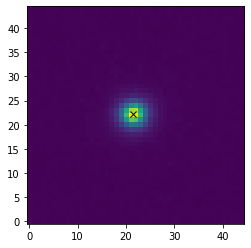

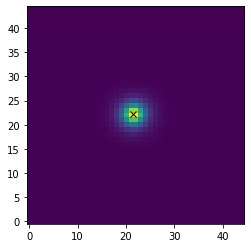

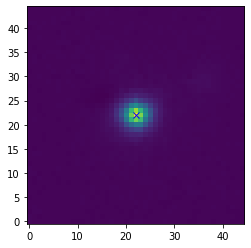

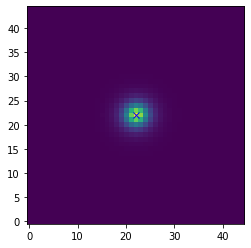

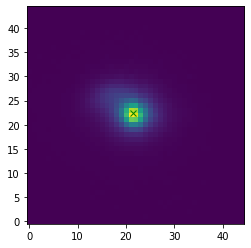

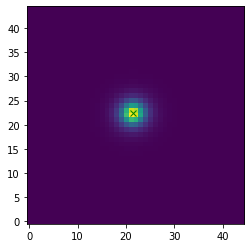

In [8]:
z = {"HE0040-1105":0.041692}


objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])

1.5935528
HE0021-1819
1.5935528
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 4.17543606e+00  2.21541996e+01  2.21906891e+01  9.49582425e-02
  9.90733759e-02 -1.31534077e-02  2.31143555e+00  3.10225780e+00
  3.33102544e+00  6.33793206e-01  3.66903213e+00  3.93959502e+00
  3.64196429e-01  1.00115432e+00] [0.04698042 0.01185972 0.0150418  0.00487323 0.00513146 0.00188401
 0.06598679 0.08007366 0.08773249 0.06106934 0.03960109 0.04371912
 0.02123657 0.00263701]
[ 0.37230516 22.03008503 22.36206008  1.00898661] [0.0010175  0.00624575 0.00816848 0.00165099]
[ 1.9531101  22.13002407 22.09167922  1.004817  ] [0.00201791 0.00234037 0.00307664 0.0004165 ]


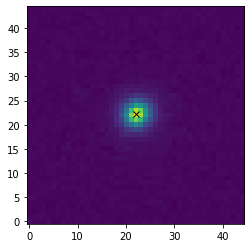

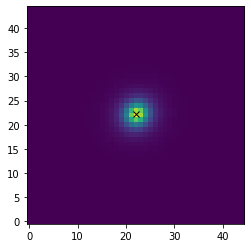

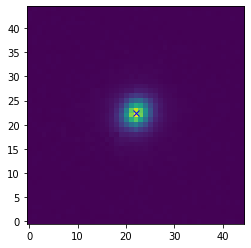

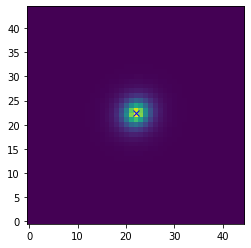

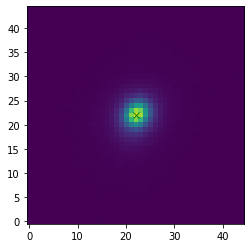

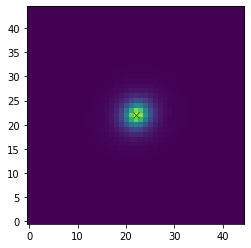

1.5767037
HE0040-1105
1.5767037
21 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 1.95513580e+01  2.15245129e+01  2.21690538e+01  8.89385181e-02
  9.93976798e-02 -3.50065354e-03  2.61951699e+00  3.16730466e+00
  3.35855418e+00  1.61488826e-01  3.48645952e+00  3.69698038e+00
  3.32634012e-01  1.00108229e+00] [0.11804064 0.00663737 0.00552374 0.00175565 0.00188077 0.00079592
 0.02730959 0.02998495 0.03299692 0.03661248 0.01510996 0.01708212
 0.01024876 0.00125674]
[ 0.66730146 22.07060726 22.04864179  1.00213048] [0.00317609 0.00861385 0.00873503 0.00246773]
[ 4.12838282 21.36657706 22.34736286  1.11004143] [0.0045331  0.00312569 0.00246183 0.00059812]


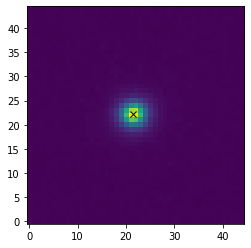

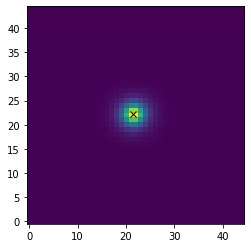

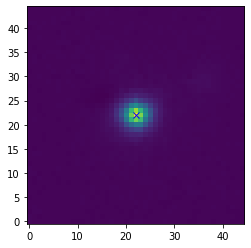

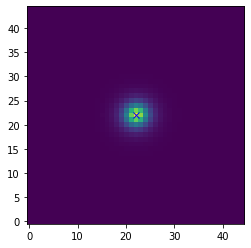

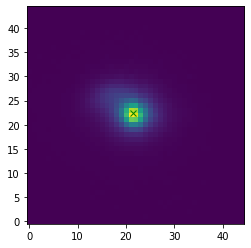

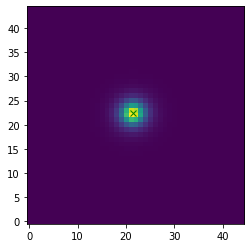

1.6356565
HE0108-4743
1.6356565
21 21
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """


[ 7.38087659e+00  2.22068554e+01  2.14617524e+01  1.61503043e-02
  1.62961744e-02  5.39861578e-04  3.44882666e+00  7.78431717e+00
  7.91965776e+00 -6.53449512e-01  7.34537718e+00  7.47308622e+00
  1.84082465e-01  1.00046046e+00] [1.70354986e-01 4.21501249e-02 4.69732151e-02 1.81162035e-03
 1.87966099e-03 4.86549776e-04 2.63317274e-01 4.45802035e-01
 4.51838315e-01 4.94077654e-01 1.29197706e-01 1.32352929e-01
 5.06602692e-02 4.13893712e-03]
[ 0.52601949 21.63678118 21.42723065  0.98559982] [0.00387951 0.03635472 0.0464196  0.00415875]
[ 1.03110236 20.2395702  21.47786855  1.00897099] [0.00311592 0.02128996 0.01484435 0.00172664]


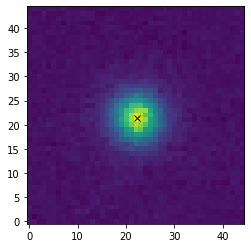

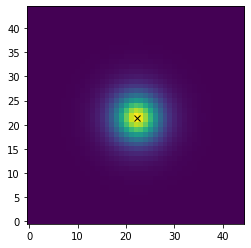

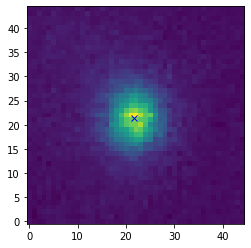

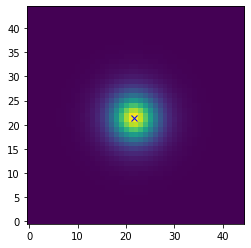

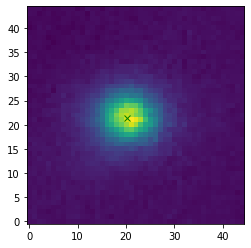

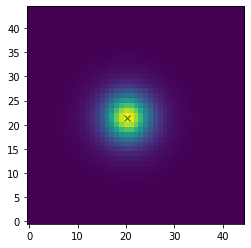

1.6499506
HE0114-0015
1.6499506
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 5.92470711e+00  2.17974757e+01  2.15112643e+01  1.29696420e-01
  1.43181790e-01 -4.69642960e-04  2.47727333e+00  2.64271243e+00
  2.77678880e+00  1.74060203e-02  3.00325855e+00  3.15562701e+00
  3.06982017e-01  1.01482747e+00] [0.11574256 0.02098074 0.02345218 0.01019009 0.01119237 0.00482758
 0.12053152 0.10750128 0.11424678 0.1795821  0.0487794  0.05319003
 0.04502383 0.00629142]
[ 0.05427297 21.88919895 21.89765467  1.02609487] [0.00221274 0.06822768 0.09583271 0.02946082]
[ 0.56880382 21.84682551 21.70282303  1.07884255] [0.00206849 0.00757128 0.00790814 0.0026939 ]


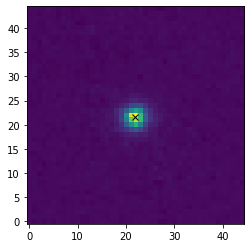

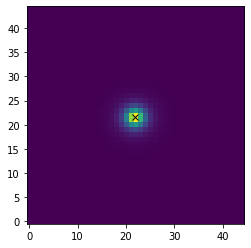

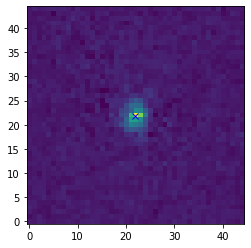

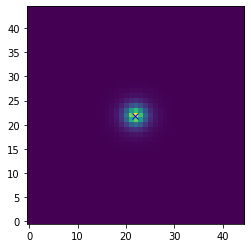

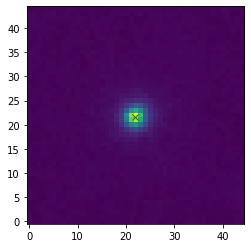

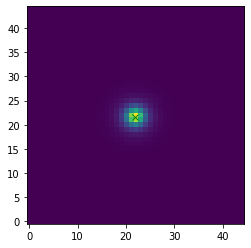

1.6265484
HE0119-0118
1.6265484
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """


[ 4.11022065e+01  2.18064646e+01  2.17383733e+01  7.26492288e-02
  7.91088941e-02  2.02401657e-03  2.84414691e+00  3.55191650e+00
  3.71405038e+00 -1.51821102e-01  3.73187482e+00  3.90222324e+00
  2.92237407e-01  1.00499920e+00] [0.80421128 0.01459129 0.01552097 0.00393044 0.00422619 0.00134428
 0.08108559 0.09536148 0.09975199 0.09353853 0.04590385 0.04857102
 0.02703386 0.00369093]
[ 1.89731045 21.55361645 21.65400099  0.98983157] [0.00489326 0.0055653  0.00482569 0.0016179 ]
[ 2.78986584 21.69856261 21.64907039  0.98824193] [0.00444156 0.0038609  0.00322771 0.00130056]


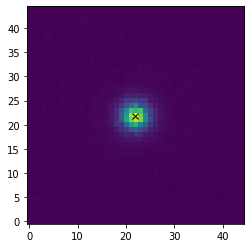

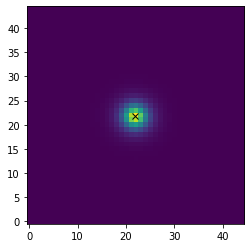

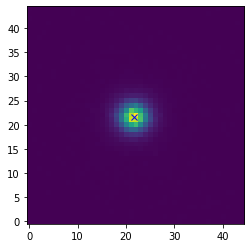

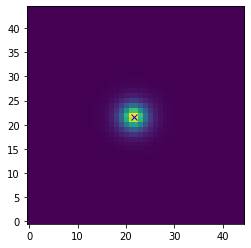

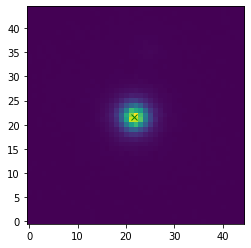

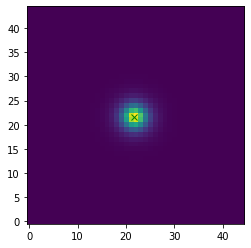

1.4443191
HE0212-0059
1.4443191
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 5.07551304e+01  2.24019272e+01  2.16702301e+01  1.83121692e-01
  1.77929862e-01 -2.18517374e-04  1.62449390e+00  2.33683139e+00
  2.37070974e+00 -2.10319366e-02  3.40943605e+00  3.45886455e+00
  1.68453397e-01  1.01757600e+00] [3.56453236 0.04741032 0.03599121 0.01396356 0.01370639 0.00364962
 0.01871155 0.08702525 0.09024282 0.35205567 0.10828536 0.11285801
 0.04835712 0.00542826]
[ 0.19721576 22.45647033 23.38726948  1.391268  ] [0.0040895  0.0344053  0.07399813 0.02159554]
[ 2.49567954 22.30423726 21.5822287   0.99905827] [0.00337561 0.00341029 0.00411335 0.00246245]


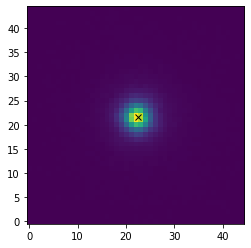

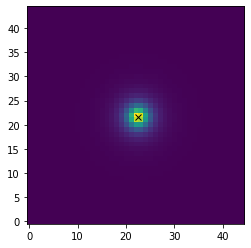

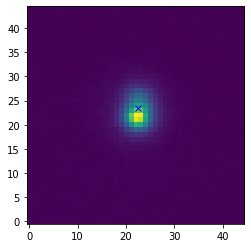

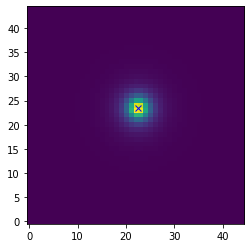

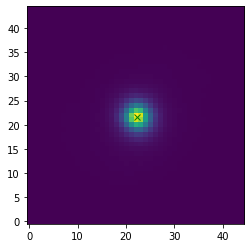

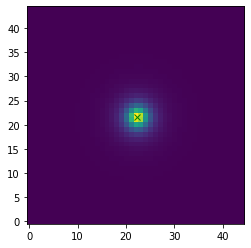

1.6447451
HE0224-2834
1.6447451
21 23
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 5.86912300e+00  2.18029342e+01  2.21313153e+01  1.48775859e-02
  1.50998786e-02 -3.03845662e-04  3.05199929e+00  8.11722228e+00
  8.21981249e+00  4.69588634e-01  8.19752713e+00  8.30113228e+00
  1.57498949e-01  9.99457815e-01] [3.65482943e-02 1.43977737e-02 1.35400035e-02 3.21312754e-04
 3.49570275e-04 1.28236886e-04 4.14364898e-02 9.14114366e-02
 9.14244433e-02 3.06131967e-01 3.81580920e-02 3.63870488e-02
 2.39325174e-02 9.68670409e-04]
[ 0.18217971 21.86971819 22.03978803  0.98236049] [0.00077841 0.02411638 0.01793929 0.00187085]
[ 0.54919512 20.13875225 22.8047044   0.93056968] [0.00087395 0.01014518 0.00698365 0.00081309]


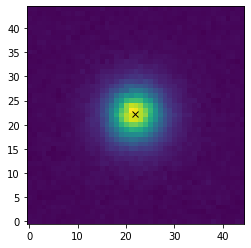

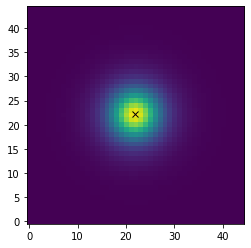

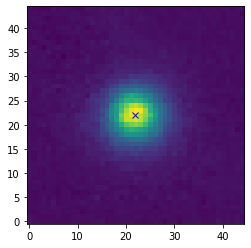

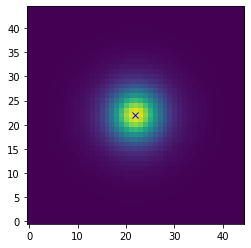

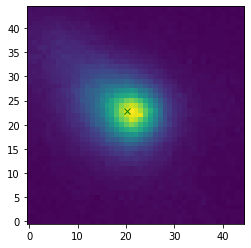

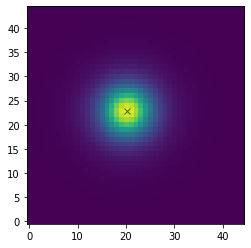

1.6146098
HE0227-0913
1.6146098
21 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """


[ 5.37367301e+01  2.15730445e+01  2.15460785e+01  3.64605545e-02
  3.73781707e-02 -8.34557100e-04  2.42201814e+00  5.16125715e+00
  5.24869808e+00  3.69015055e-01  5.94185824e+00  6.04252396e+00
  1.81773361e-01  1.00193025e+00] [1.38338049e-01 4.22206352e-03 3.63553126e-03 2.71291709e-04
 2.72338808e-04 1.22637504e-04 8.47024146e-03 1.92497740e-02
 1.92235756e-02 4.63953710e-02 1.18285947e-02 1.17384576e-02
 8.77810971e-03 3.72187893e-04]
[ 0.1168261  21.71840299 21.67034351  0.99830157] [0.00089031 0.02475313 0.02424009 0.00318327]
[ 1.1390506  21.58485611 21.65638368  0.98760087] [0.00090067 0.00323933 0.00299917 0.00039503]


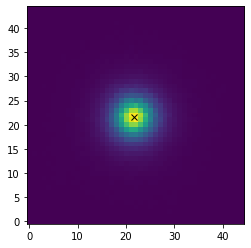

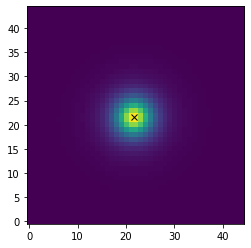

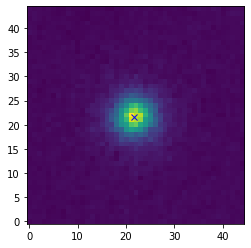

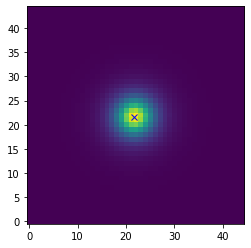

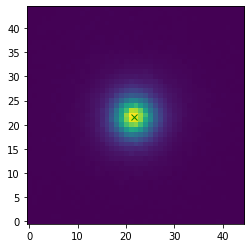

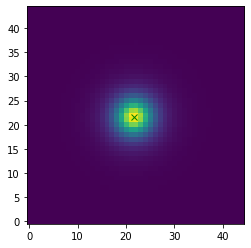

1.6279633
HE0232-0900
1.6279633
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 1.43777934e+02  2.20776847e+01  2.24415533e+01  3.46364345e-02
  3.62272288e-02  6.57766318e-04  2.48715017e+00  5.24917814e+00
  5.37827818e+00 -1.96037645e-01  5.95173845e+00  6.09811750e+00
  2.17788328e-01  1.00164166e+00] [6.45815629e-01 4.55723739e-03 5.05613452e-03 3.36826874e-04
 3.46030363e-04 1.07686816e-04 1.06119467e-02 2.49859189e-02
 2.59377281e-02 3.24005003e-02 1.54861512e-02 1.59608652e-02
 7.05902482e-03 4.98992285e-04]
[ 4.26068661 21.36514227 22.23050039  0.91770124] [0.00809276 0.00784844 0.00695712 0.00139901]
[10.33491556 21.97139544 20.90962535  0.90383718] [0.00894455 0.00276542 0.00414081 0.00065298]


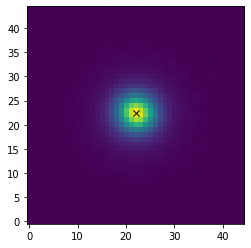

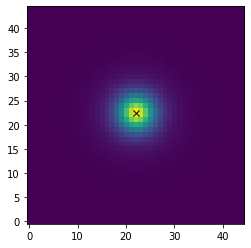

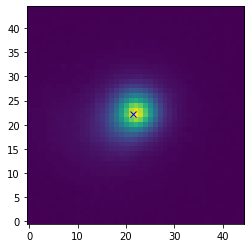

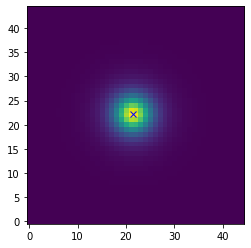

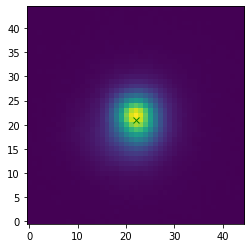

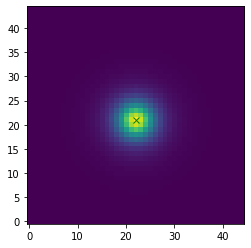

1.3951703
HE0253-1641
1.3951703
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """


[3.42333806e+01 2.18274518e+01 2.20643715e+01 5.64173257e-02
 5.51405748e-02 3.67838154e-03 2.62588986e+00 4.16212477e+00
 4.31001971e+00 6.18355543e-01 4.57519329e+00 4.73776600e+00
 2.59713230e-01 1.00058196e+00] [0.37547099 0.01189794 0.01433872 0.00184482 0.00166664 0.00067777
 0.04273878 0.06654998 0.06674275 0.20419297 0.03635836 0.03463824
 0.02166391 0.00181564]
[ 1.39664736 21.68492717 22.09617787  0.98755573] [0.00382931 0.00678065 0.00604855 0.00109802]
[ 4.43214211 21.56027515 21.56274077  0.97321033] [0.00518069 0.00304981 0.00284413 0.00058709]


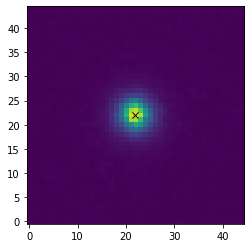

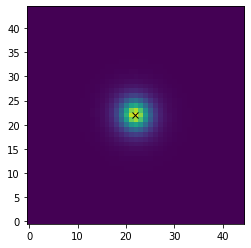

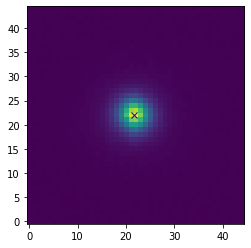

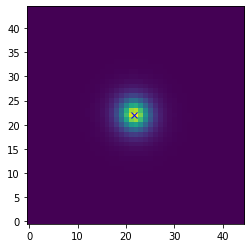

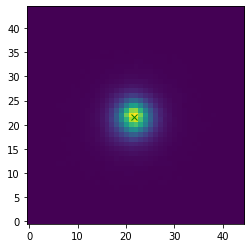

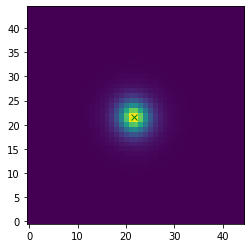

1.3926791
HE0345+0056
1.3926791
21 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 1.87499759e+02  2.15314014e+01  2.14132860e+01  6.48953891e-02
  6.71303315e-02  2.15973508e-03  2.35764043e+00  3.84709750e+00
  3.93875188e+00 -3.84143278e-01  4.49820573e+00  4.60537231e+00
  2.14472192e-01  1.00596117e+00] [8.96448531e-01 4.04464732e-03 3.77163187e-03 5.63523040e-04
 5.90037697e-04 2.04163093e-04 7.67278801e-03 1.66703149e-02
 1.74783720e-02 3.32641268e-02 1.17534028e-02 1.27836600e-02
 6.32920916e-03 5.87487350e-04]
[ 2.31919283 21.53577568 21.39489093  1.01803265] [0.00421464 0.00554875 0.00544833 0.00129664]
[ 4.21444427 21.50164987 21.30506313  0.92822577] [0.00439508 0.00337283 0.00358657 0.00098575]


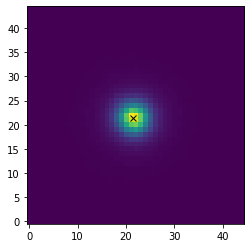

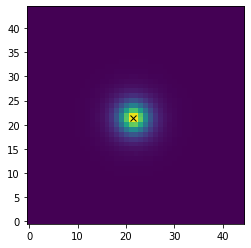

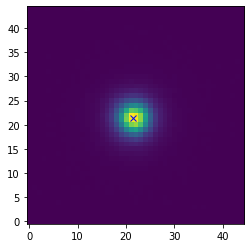

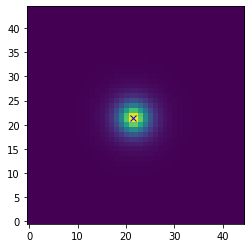

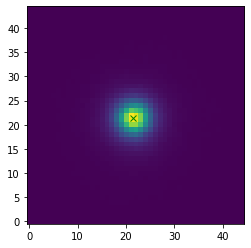

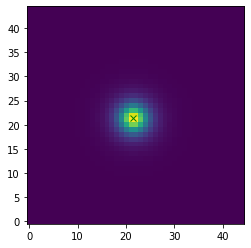

1.3910508
HE0351+0240
1.3910508
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """


[ 4.66308400e+01  2.19439833e+01  2.17297289e+01  8.69324945e-02
  7.98909030e-02 -2.16439836e-03  2.57146371e+00  3.38846681e+00
  3.54155221e+00 -1.49103818e-01  3.76946031e+00  3.93975838e+00
  2.90830837e-01  9.98015064e-01] [0.26228153 0.00586558 0.00595559 0.00185614 0.00173304 0.00066996
 0.0308117  0.03638565 0.03854743 0.04383152 0.01691834 0.01864825
 0.01228383 0.00112095]
[ 0.50964763 21.84320865 21.69077371  1.0632844 ] [0.00369174 0.02691943 0.02711612 0.00411943]
[ 8.83097366 21.96464677 21.66685443  0.99240758] [0.00965698 0.0020535  0.00233222 0.00038535]


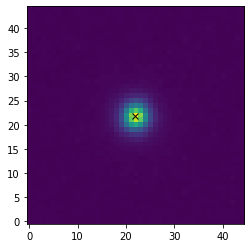

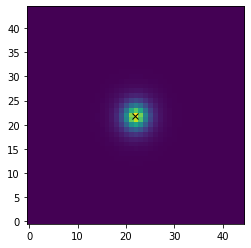

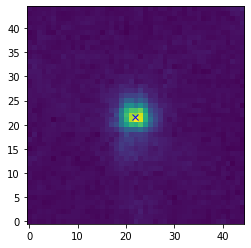

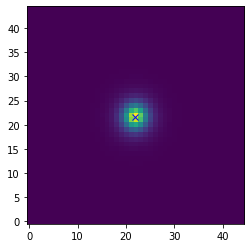

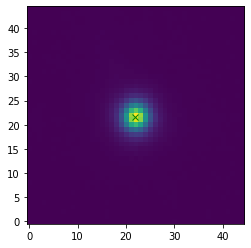

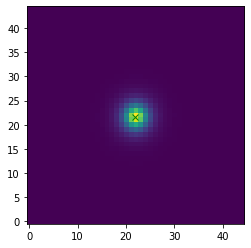

1.4130688
HE0412-0803
1.4130688
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


[ 1.18451092e+02  2.19683731e+01  2.17766049e+01  8.59701912e-02
  8.82041473e-02  4.87291180e-03  2.44432370e+00  3.33764800e+00
  3.44200169e+00 -5.70471390e-01  3.82225506e+00  3.94176031e+00
  2.44369199e-01  1.01181770e+00] [3.55295911e+00 1.82638775e-02 1.46483302e-02 2.73002603e-03
 2.77568849e-03 8.08135543e-04 2.17321528e-02 5.12570201e-02
 5.51871404e-02 7.14624957e-02 4.31804208e-02 4.62975765e-02
 1.82180690e-02 3.08050447e-03]
[ 6.16364992 22.14554888 21.87945701  0.94403057] [0.00939468 0.00385993 0.00363437 0.00187355]
[65.65965367 22.25740568 22.00702842  0.72291173] [0.02351238 0.00109251 0.0014832  0.00048686]


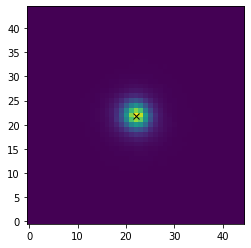

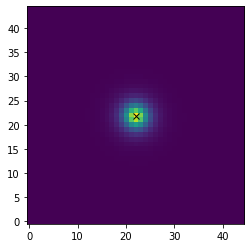

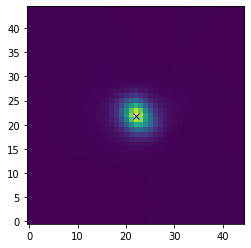

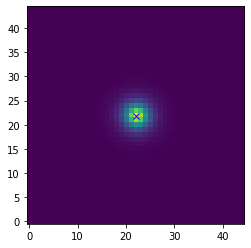

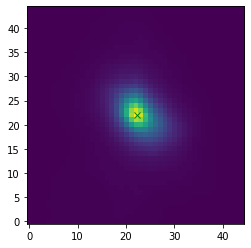

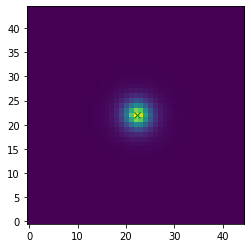

1.3098165
HE0429-0247
1.3098165
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 3.15775358e+01  2.23123504e+01  2.19061748e+01  5.45141361e-02
  5.34784616e-02 -1.86493943e-04  2.46714592e+00  4.28264682e+00
  4.32458430e+00 -8.90803911e-02  4.87837458e+00  4.92614568e+00
  1.38927603e-01  9.99987731e-01] [0.19914122 0.00657379 0.00692789 0.00098415 0.00094506 0.00032077
 0.02181545 0.03890753 0.03885452 0.16235647 0.02182006 0.02184006
 0.0211562  0.00078658]
[ 0.537692   22.6264082  21.83510722  0.99821795] [0.00184593 0.01091936 0.01134816 0.00128035]
[ 2.63578182 21.96160374 21.97415463  0.96685156] [0.0024748  0.00289416 0.00334798 0.00039346]


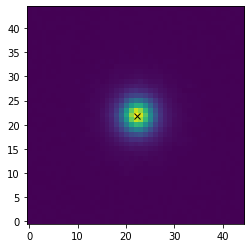

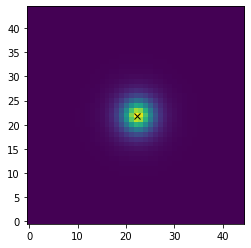

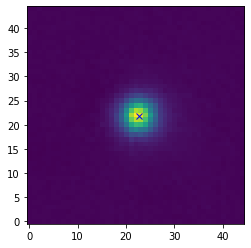

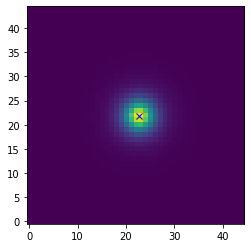

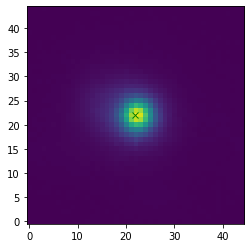

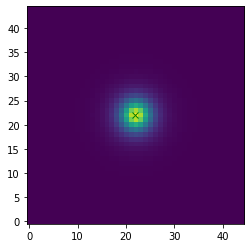

1.4312612
HE0433-1028
1.4312612
22 23
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.


[ 2.63687898e+02  2.22467242e+01  2.25009874e+01  1.40644849e-01
  1.39615332e-01 -3.10980882e-03  2.35030579e+00  2.65589508e+00
  2.68712180e+00 -6.25548933e-01  3.11098654e+00  3.14756401e+00
  1.52008931e-01  9.99196875e-01] [2.81157258e+00 5.31396190e-03 5.04871352e-03 2.45708360e-03
 2.49870030e-03 7.83520936e-04 1.59243475e-02 2.34214841e-02
 2.38430947e-02 3.33248168e-01 1.69176924e-02 1.72848271e-02
 1.79552933e-02 1.45570320e-03]
[ 6.90114204 22.28960421 22.43426085  0.98358361] [0.01032536 0.00304654 0.00256371 0.00154945]
[ 6.956379   22.24084002 22.61883321  0.94008424] [0.01265352 0.00325366 0.00330556 0.00193672]


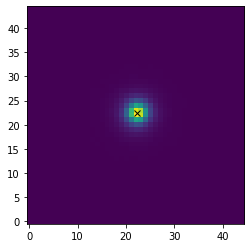

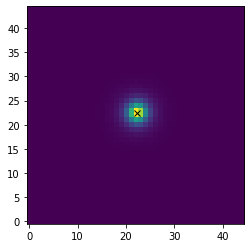

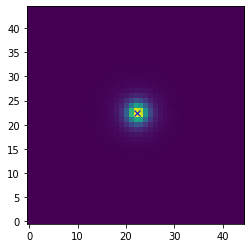

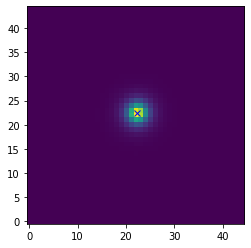

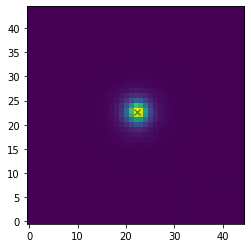

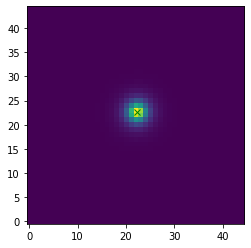

1.5838728
HE0853+0102
1.5838728
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 9.89624445e+00  2.22318233e+01  2.15203030e+01  1.55101331e-01
  1.50936514e-01 -2.67895975e-03  2.17436616e+00  2.53595696e+00
  2.57732891e+00 -2.85802691e-01  3.10776501e+00  3.15846552e+00
  1.78456838e-01  1.00344962e+00] [0.24701901 0.02086662 0.01725696 0.01106983 0.01053671 0.00453753
 0.0743374  0.08896137 0.09399717 0.41733235 0.05352644 0.05860221
 0.04643074 0.00388409]
[ 0.23380034 22.18803233 21.4804299   1.01987375] [0.00175284 0.01700262 0.01671716 0.00515785]
[ 0.84522728 22.38180998 21.71228027  1.03929369] [0.00225195 0.00486237 0.00555621 0.00148989]


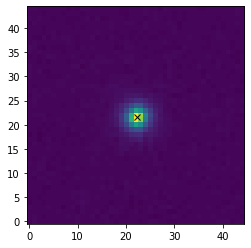

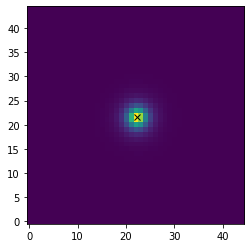

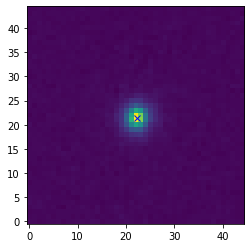

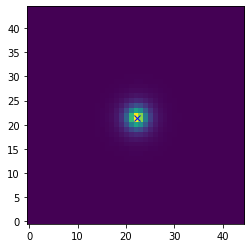

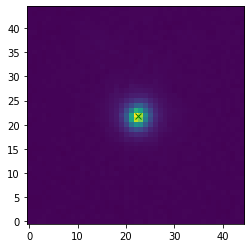

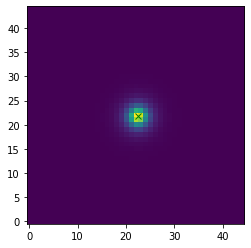

2.1357596
HE0934+0119
2.1357596
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[4.48532042e+01 2.18349629e+01 2.15719060e+01 1.01211888e-01
 9.89528519e-02 4.56203597e-04 2.33222762e+00 3.14293444e+00
 3.17933203e+00 9.96330763e-02 3.69793857e+00 3.74076354e+00
 1.50881800e-01 9.99831899e-01] [0.42727548 0.00857112 0.00868325 0.00234978 0.00243535 0.00102067
 0.02451519 0.0371702  0.03885516 0.23167513 0.02371871 0.02527001
 0.03279414 0.00109853]
[ 1.01191813 21.87423003 21.47888211  0.99298239] [0.0055214  0.01129707 0.01166407 0.00181744]
[ 2.19400786 21.71544205 21.63502737  0.98447222] [0.00352013 0.0032604  0.00484038 0.00064591]


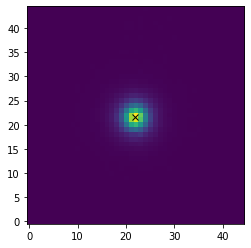

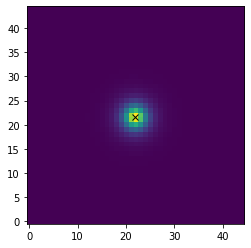

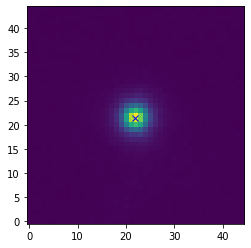

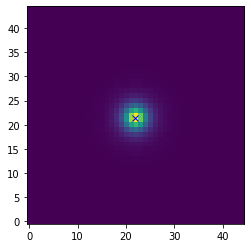

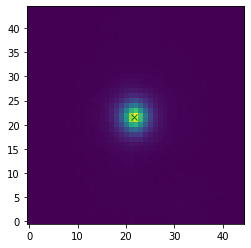

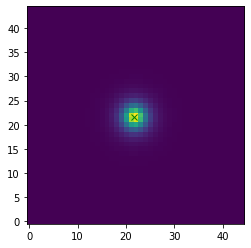

1.7478528
HE1011-0403
1.7478528
22 21
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[4.45410922e+01 2.22706026e+01 2.15400718e+01 7.55879688e-02
 7.43307241e-02 6.96762806e-04 2.47999064e+00 3.63508886e+00
 3.67011050e+00 2.53030361e-01 4.12843027e+00 4.16820492e+00
 1.37817734e-01 1.00120646e+00] [0.72793529 0.01524777 0.01672396 0.00299766 0.00293024 0.00127205
 0.04804622 0.07059817 0.0719545  0.41292257 0.04120853 0.04132069
 0.03977331 0.00167486]
[ 0.61312589 22.29808218 21.54540195  1.00591347] [0.00336152 0.01382297 0.01358988 0.00225041]
[ 1.23057744 22.20248924 21.49918704  0.9810093 ] [0.00363933 0.00674393 0.00678132 0.00106011]


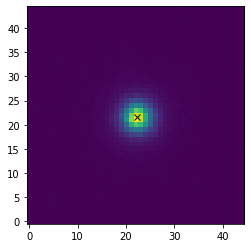

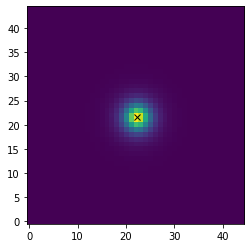

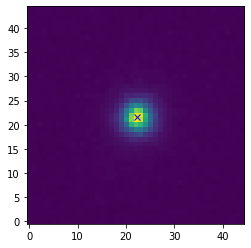

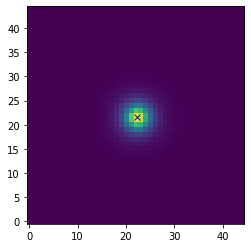

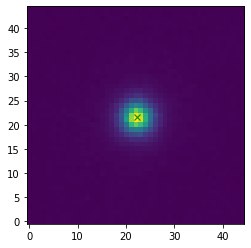

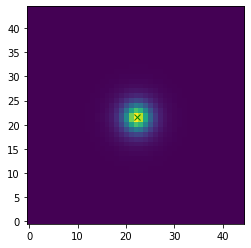

1.5213356
HE1017-0305
1.5213356
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 5.45692388e+01  2.21237039e+01  2.18304177e+01  7.83646127e-02
  8.13535489e-02  5.25369994e-03  2.57461399e+00  3.47353546e+00
  3.60757340e+00 -5.26771576e-01  3.86139650e+00  4.01040134e+00
  2.70053196e-01  9.96821096e-01] [0.41369465 0.00590116 0.00616717 0.00159769 0.00161515 0.0004683
 0.02589507 0.03457804 0.03613057 0.03755946 0.01842369 0.01967805
 0.00964255 0.00077318]
[ 0.49675599 22.14639612 21.7622508   0.99669053] [0.00533839 0.02330043 0.02351545 0.00429535]
[ 1.35070165 22.02357624 21.96095565  1.00982756] [0.00586683 0.01004928 0.00871684 0.00186084]


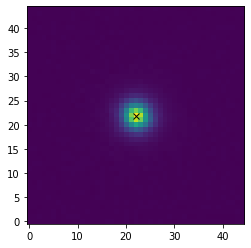

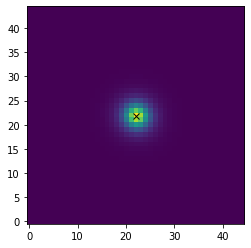

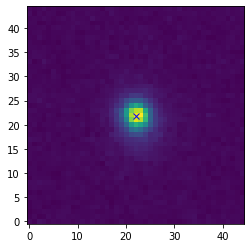

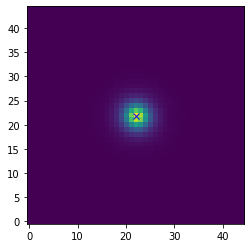

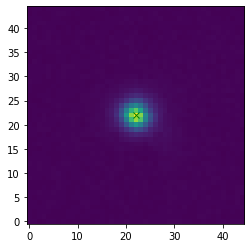

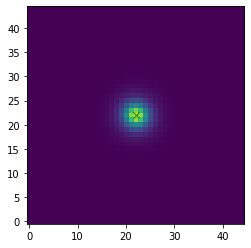

1.5548333
HE1029-1831
1.5548333
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 3.20175933e+01  2.15311889e+01  2.16590458e+01  7.77205167e-02
  7.87084487e-02 -2.70893466e-03  2.89557536e+00  3.54315518e+00
  3.60907945e+00  6.10545802e-01  3.68531152e+00  3.75388075e+00
  1.90259817e-01  1.00432224e+00] [0.82206454 0.02184368 0.02365752 0.00572643 0.00557212 0.00192012
 0.10531853 0.12263183 0.12681681 0.50486098 0.05986927 0.06288103
 0.05034295 0.00660978]
[ 1.70481557 21.22223712 21.98704604  1.08733756] [0.00544833 0.01034126 0.00868997 0.00341794]
[ 0.42175861 21.94585224 21.5070038   0.89669076] [0.00511634 0.02119901 0.0234311  0.01217604]


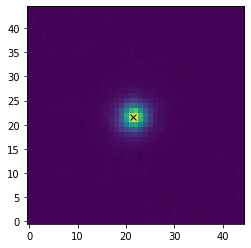

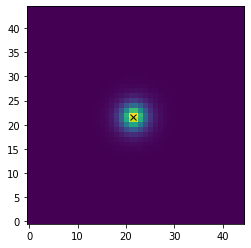

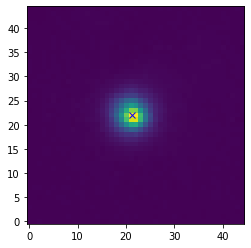

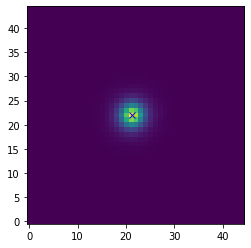

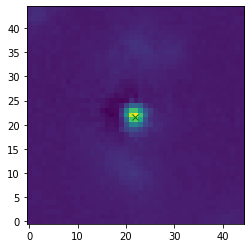

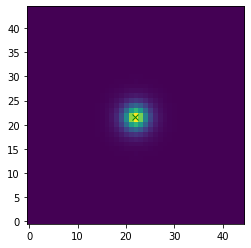

1.2789029
HE1107-0813
1.2789029
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """


[ 1.34152378e+02  2.21379170e+01  2.20719608e+01  1.16406601e-01
  1.14924904e-01 -8.15155188e-03  2.41783396e+00  2.88905976e+00
  2.99445234e+00 -6.95495366e-01  3.32931669e+00  3.45076980e+00
  2.62969840e-01  1.00522523e+00] [4.55074132e+00 2.20527454e-02 2.12763067e-02 5.14629460e-03
 5.33657606e-03 1.77764774e-03 3.55739692e-02 6.17278674e-02
 7.17030203e-02 5.78060085e-01 4.63928033e-02 5.67184466e-02
 2.96413364e-02 3.37292875e-03]
[ 0.1749289  22.31827556 22.14520802  0.97446413] [0.00327091 0.04212049 0.03487426 0.01375189]
[ 0.62068608 21.15554959 21.66464698  0.72635319] [0.00627821 0.02892912 0.01442918 0.0055997 ]


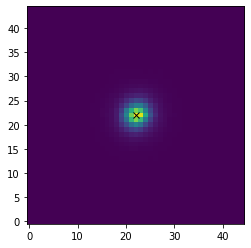

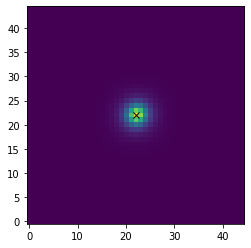

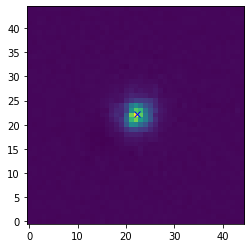

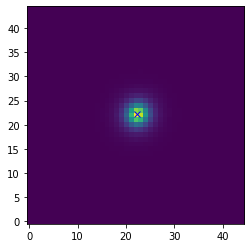

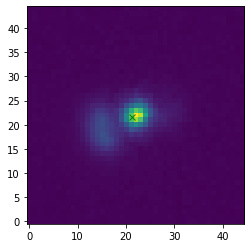

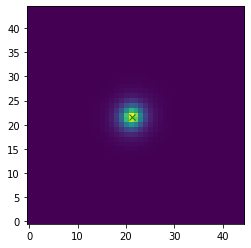

1.7699608
HE1108-2813
1.7699608
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[8.49715389e+01 2.18009495e+01 2.17708662e+01 2.23027443e-01
 2.08502018e-01 6.09017236e-03 2.40967357e+00 2.11458564e+00
 2.19322780e+00 1.98506496e-01 2.44156583e+00 2.53236849e+00
 2.65382584e-01 1.00864260e+00] [0.66279533 0.00568331 0.00556957 0.0046581  0.00440445 0.00201299
 0.02359327 0.02144376 0.023122   0.06783462 0.01275244 0.01485081
 0.01737795 0.00145632]
[ 2.37522366 22.15998326 21.8039097   1.06270977] [0.01282598 0.00892162 0.01059773 0.00285959]
[ 4.46995112 22.09375426 21.75467313  1.06812793] [0.01359465 0.00604529 0.00602886 0.00146955]


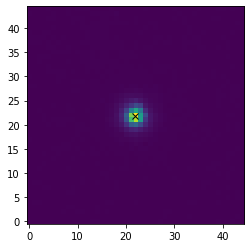

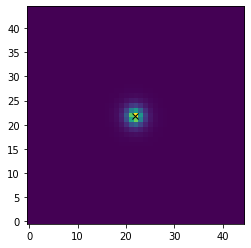

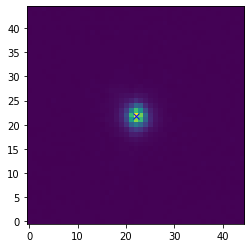

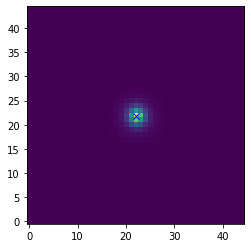

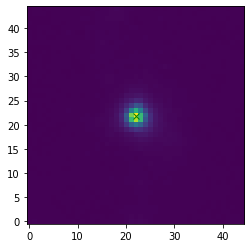

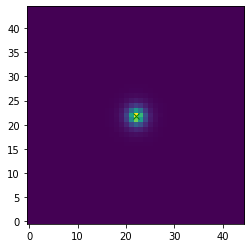

1.4976588
HE1126-0407
1.4976588
23 23
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 1.75545182e+02  2.26089644e+01  2.23293032e+01  7.75749057e-02
  8.18941251e-02 -2.13039041e-03  2.50249670e+00  3.48912036e+00
  3.59613373e+00  2.29110509e-01  3.94219936e+00  4.06310893e+00
  2.42136853e-01  1.00109980e+00] [6.60157286e-01 3.36455981e-03 3.35758144e-03 5.83106614e-04
 5.87904002e-04 2.33113230e-04 7.85984261e-03 1.27172445e-02
 1.32939565e-02 2.55839196e-02 8.60182484e-03 8.84465175e-03
 6.78273201e-03 5.04867921e-04]
[ 0.59426824 22.67363826 22.32894983  0.99902349] [0.00217247 0.00924801 0.00946602 0.00132473]
[ 3.57722454 22.8659969  22.92063886  0.96579117] [0.00274025 0.0020073  0.00270515 0.00030684]


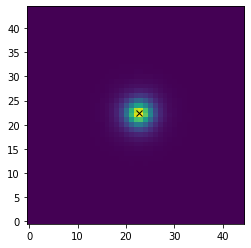

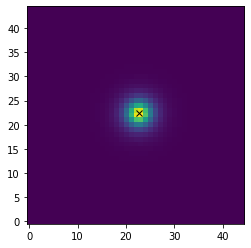

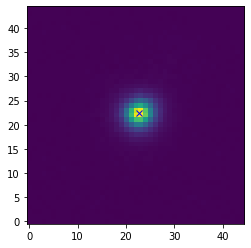

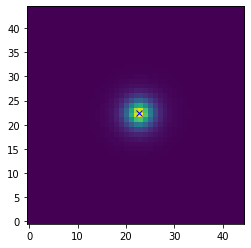

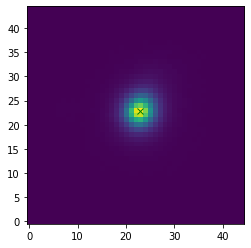

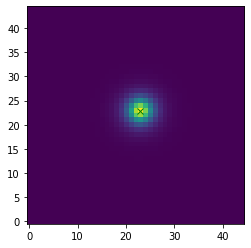

2.2194164
HE1237-0504
2.2194164
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 1.75588830e+02  2.18502817e+01  2.18017957e+01  1.36298168e-01
  1.40604845e-01  6.57287954e-03  2.50967210e+00  2.65017550e+00
  2.72648197e+00 -4.95380407e-01  2.98941075e+00  3.07548482e+00
  2.34927711e-01  1.00111428e+00] [5.47516828e-01 1.99575485e-03 2.33905689e-03 9.73797836e-04
 1.04476743e-03 3.62363267e-04 8.30145330e-03 9.82894030e-03
 9.64850561e-03 2.33841487e-02 6.08257237e-03 5.76089655e-03
 4.68304135e-03 4.46923650e-04]
[ 2.03483691 21.7039446  21.76637478  1.00321352] [0.00554319 0.00539883 0.00485158 0.00130459]
[16.10242443 22.25488878 21.86636354  0.93579718] [0.00689554 0.00103043 0.00088612 0.0002862 ]


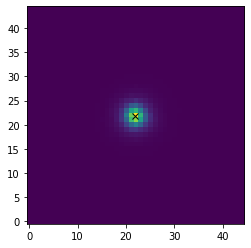

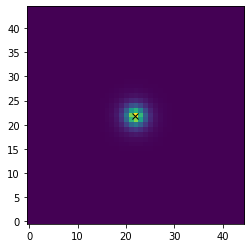

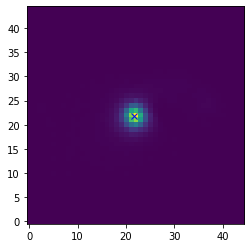

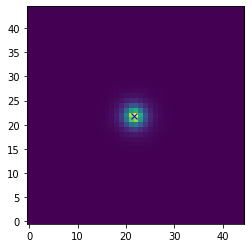

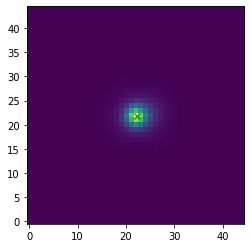

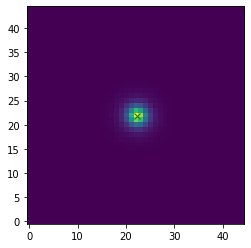

1.5200477
HE1248-1356
1.5200477
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 9.27517277e+00  2.23530887e+01  2.22449073e+01  1.04974167e-01
  9.08530900e-02 -7.85057713e-03  3.37985284e+00  3.07159239e+00
  3.33638718e+00 -2.53698977e-01  2.93092240e+00  3.18359036e+00
  3.90426095e-01  9.96564245e-01] [0.18141665 0.01734467 0.02224153 0.01039667 0.00918443 0.00296513
 0.21470337 0.14902005 0.165473   0.09637302 0.05029469 0.05622638
 0.03732104 0.00468612]
[ 0.72906876 22.44108376 22.10210379  1.3003826 ] [0.00465247 0.01815273 0.01822079 0.00757287]
[ 4.90723039 22.65387032 22.17692782  1.16781559] [0.00783844 0.00359792 0.0031508  0.00113157]


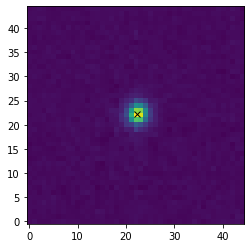

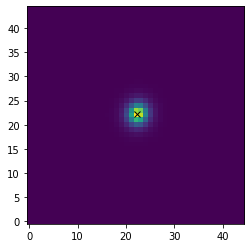

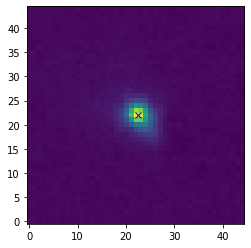

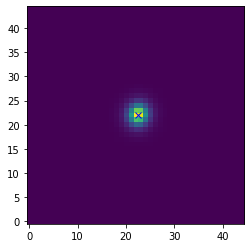

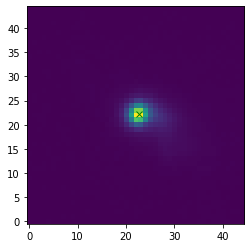

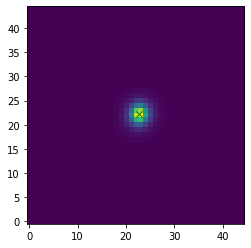

1.5194657
HE1330-1013
1.5194657
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[1.63863002e+01 2.20168180e+01 2.19772357e+01 1.11238802e-01
 1.09359468e-01 5.56803547e-03 2.15595861e+00 2.97169989e+00
 3.05194781e+00 6.22640362e-01 3.65989500e+00 3.75872696e+00
 2.27808305e-01 1.00368416e+00] [0.28412494 0.02109059 0.01950664 0.00576182 0.00623231 0.0028121
 0.05928852 0.08053408 0.08570247 0.53943251 0.04704988 0.05407692
 0.05453441 0.00282451]
[ 0.16463722 21.93410986 22.12386397  0.99418779] [0.00226248 0.03211981 0.03292555 0.00600704]
[ 0.73295683 22.18410081 21.76849625  1.02679482] [0.00283985 0.01097765 0.01154476 0.00158423]


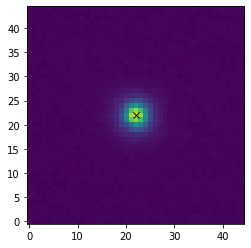

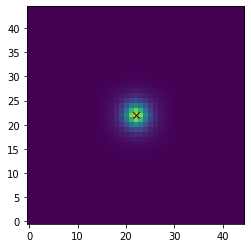

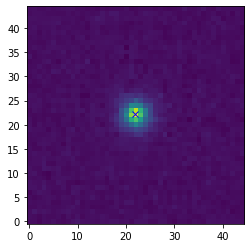

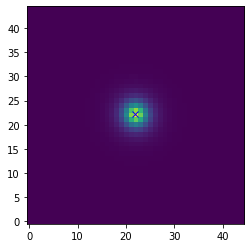

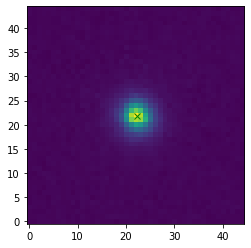

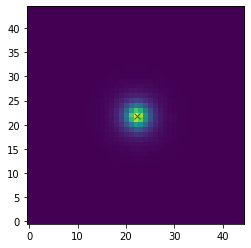

1.6310822
HE1353-1917
1.6310822
22 23
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 1.67920552e+01  2.20238558e+01  2.16679076e+01  7.70462361e-02
  7.70909969e-02  9.03651409e-03  2.47255476e+00  3.50098062e+00
  3.71261899e+00 -7.82921518e-01  3.98297154e+00  4.22374682e+00
  3.32807294e-01  1.02630249e+00] [0.48534523 0.03019528 0.02842794 0.0048222  0.00474437 0.00222405
 0.06942951 0.11200716 0.11115439 0.70835309 0.07061477 0.06936076
 0.0341559  0.00320549]
[ 0.1564267  25.314297   17.18686988  1.64131915] [0.00109461 0.03048813 0.02952184 0.01661651]
[ 1.62266479 21.94376254 23.32466955  1.13134049] [0.00360124 0.0092329  0.02028873 0.00165854]


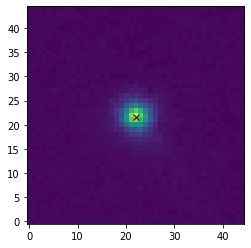

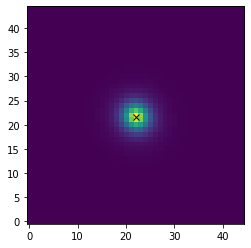

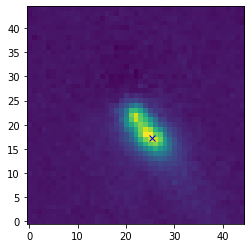

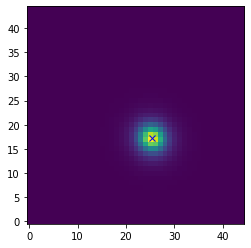

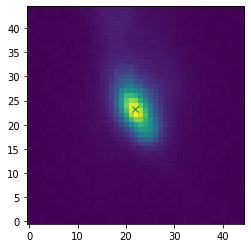

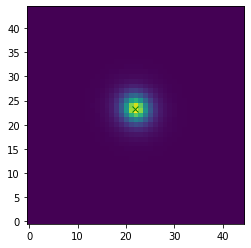

1.4134127
HE1417-0909
1.4134127
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 2.00202955e+01  2.21370507e+01  2.21095421e+01  9.68180380e-02
  9.80085271e-02  7.40111267e-03  2.35632066e+00  3.14407263e+00
  3.26746514e+00 -7.05654871e-01  3.67738445e+00  3.82170736e+00
  2.72216560e-01  1.00217779e+00] [0.13383603 0.00584715 0.00614902 0.00137417 0.0014537  0.00055548
 0.01614249 0.02256709 0.02386376 0.14900334 0.01412079 0.01514038
 0.00951684 0.00088829]
[ 0.55807018 22.34345124 22.01098546  0.99860771] [0.00331731 0.01173048 0.0109733  0.002313  ]
[ 2.98719114 22.16530472 22.16131858  0.99743068] [0.00426059 0.0032145  0.00308016 0.00061088]


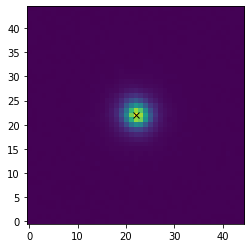

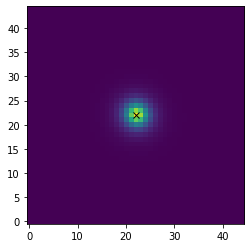

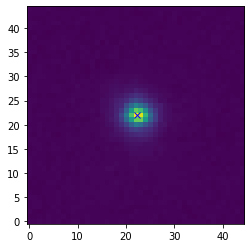

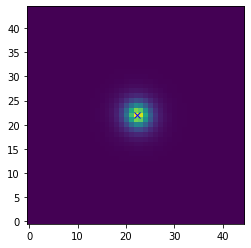

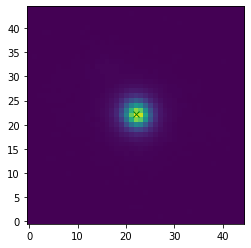

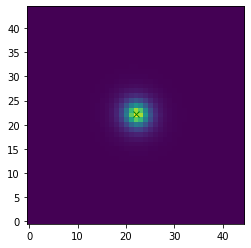

1.6191043
HE2128-0221
1.6191043
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[7.01320693e+00 2.17084363e+01 2.14002793e+01 9.28459060e-02
 9.19302792e-02 1.53239669e-03 2.45626739e+00 3.27419262e+00
 3.30597863e+00 5.16103777e-01 3.73910909e+00 3.77540852e+00
 1.38336418e-01 9.97952388e-01] [0.09100599 0.01141307 0.01203131 0.00355593 0.00368009 0.00113396
 0.04750768 0.06418027 0.0640816  0.48063394 0.03458018 0.03472075
 0.03376443 0.00195439]
[ 0.36778411 21.72328634 21.63183836  0.98712197] [0.00414894 0.03029343 0.02482888 0.00558978]
[ 1.47445486 21.73774425 21.71989049  0.98040115] [0.00446797 0.0066852  0.00719607 0.0013106 ]


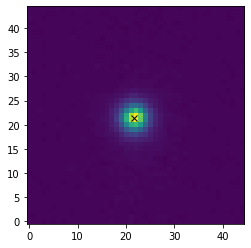

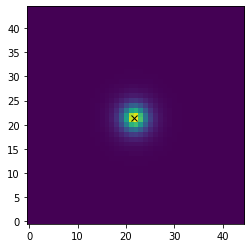

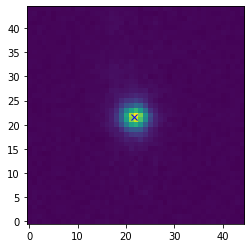

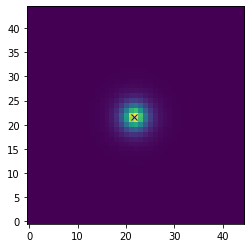

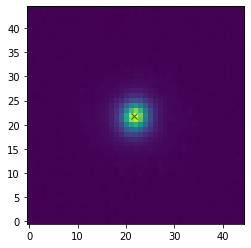

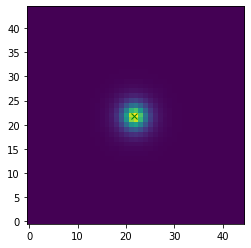

1.8923526
HE2211-3903
1.8923526
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 4.89243727e+01  2.18833301e+01  2.21146660e+01  2.23046114e-01
  2.08580379e-01 -1.20215115e-02  2.35463374e+00  2.10716600e+00
  2.20108033e+00 -3.46689751e-01  2.46561198e+00  2.57550189e+00
  2.88988326e-01  1.01894830e+00] [1.64663983 0.0176174  0.01844441 0.01111652 0.01103823 0.00488372
 0.0442925  0.05361367 0.05953463 0.13575068 0.04022856 0.04510864
 0.03855172 0.00276422]
[ 0.19183224 22.10760352 22.41379674  1.04148026] [0.00703467 0.0746007  0.05654223 0.01492629]
[ 4.82457133 21.88332933 22.32940138  1.00975067] [0.0062913  0.00251719 0.00233126 0.00052388]


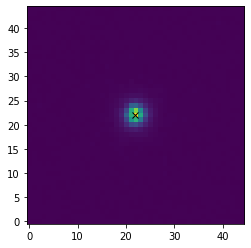

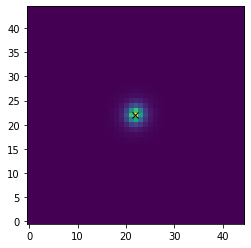

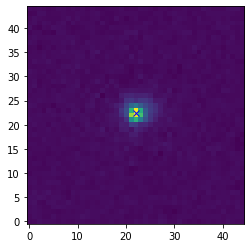

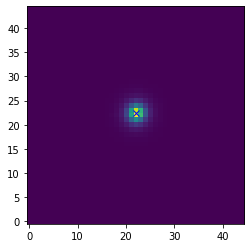

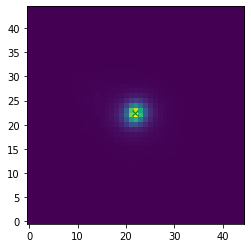

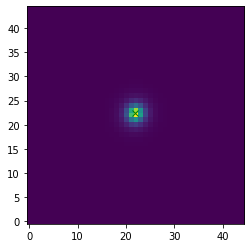

1.7505724
HE2222-0026
1.7505724
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 7.33805817e+00  2.23069442e+01  2.20789980e+01  1.40254363e-02
  1.45840801e-02  6.36347110e-04  7.15894935e+00  8.23997693e+00
  8.48757821e+00 -4.25165475e-01  5.25461929e+00  5.41251421e+00
  2.39777756e-01  1.34216575e+00] [1.31342352e+01 6.05694032e-01 8.14648252e-01 3.94224885e-02
 3.83373914e-02 2.12673886e-02 1.62990507e+03 8.96909792e+01
 1.07607221e+02 4.69674538e-01 1.34237299e+00 1.52803158e+00
 1.53656652e-01 2.23810033e+00]
[ 0.03786378 22.47568096 21.90078205  1.08956875] [0.00088858 0.04573337 0.04454508 0.01274387]
[ 0.2322838  22.29550275 21.87638499  1.1022232 ] [0.00078395 0.00742066 0.00675677 0.00197078]


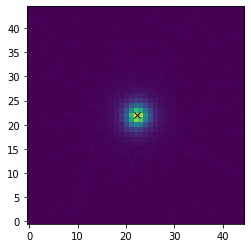

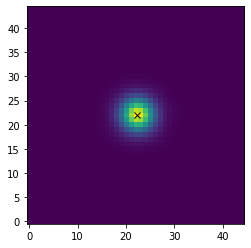

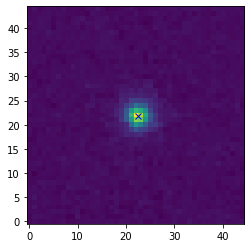

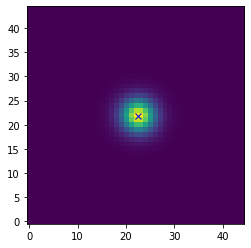

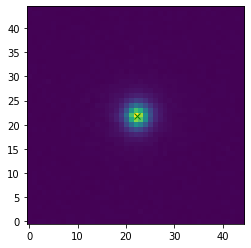

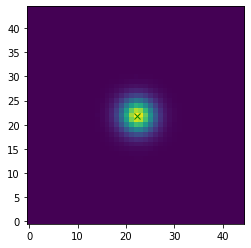

1.4481127
HE2233+0124
1.4481127
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[ 5.53602393e+00  2.19292375e+01  2.21518756e+01  3.00723592e-03
  3.07669570e-03 -1.07119097e-05  2.56152741e+01  1.80272198e+01
  1.82366851e+01  7.65060087e-02  5.97126841e+00  6.04065091e+00
  1.51128868e-01  1.13888417e+00] [8.27376203e-01 1.01588605e-01 9.77652320e-02 2.42760108e-03
 2.59909415e-03 2.56934568e-04 6.63234900e+02 4.14693228e+01
 4.42123693e+01 3.95583547e-01 3.15518954e-01 3.19915188e-01
 8.82836720e-02 3.55612180e-02]
[ 0.02685237 21.92242453 22.34810063  1.02887531] [0.00063614 0.05310697 0.06318196 0.0115502 ]
[ 0.11754572 21.741008   22.05432419  1.06059592] [0.00059007 0.01583424 0.01892495 0.00297258]


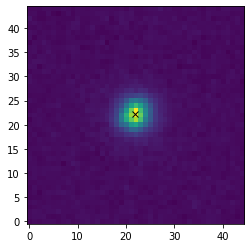

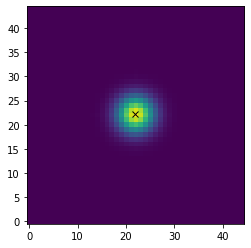

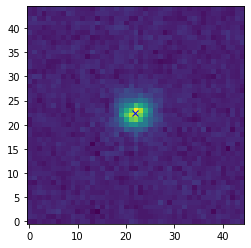

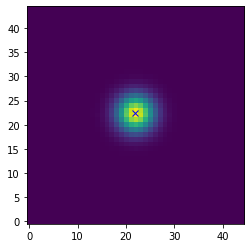

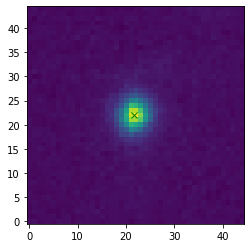

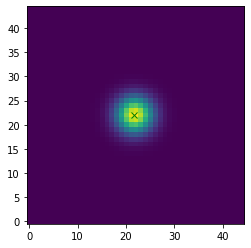

1.857164
HE2302-0857
1.857164
21 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """


[5.51352083e+01 2.24324741e+01 2.19375113e+01 1.01158265e-01
 8.37233059e-02 1.83116179e-02 2.68943035e+00 3.08484933e+00
 3.53999131e+00 4.04958763e-01 3.34526010e+00 3.83882336e+00
 4.90522540e-01 1.04408713e+00] [3.04503459e+00 3.47340212e-02 2.65769268e-02 6.85302669e-03
 5.66938812e-03 2.39397058e-03 6.45125443e-02 1.02974040e-01
 1.23275102e-01 4.41381246e-02 7.22204080e-02 8.95710528e-02
 1.90859482e-02 9.87004517e-03]
[ 1.10957757 22.86913905 22.0126165   1.08872399] [0.0125905  0.02654478 0.01761227 0.01445688]
[15.42656209 21.18903963 21.59214888  0.8626546 ] [0.01572961 0.00295486 0.0015872  0.00136068]


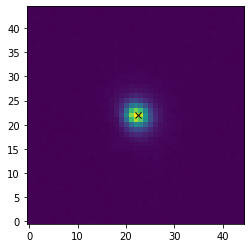

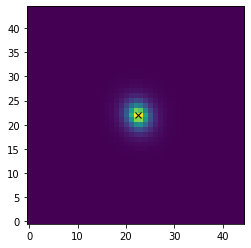

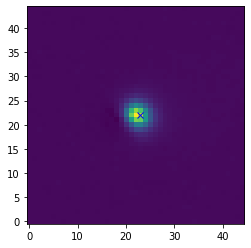

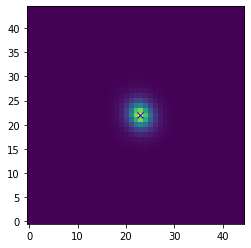

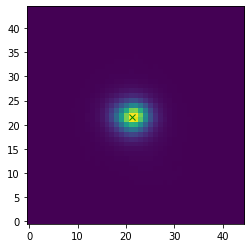

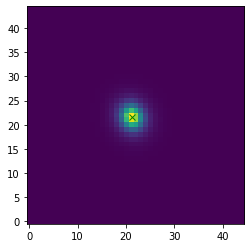

In [9]:
z = {"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}


objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])

1.2495849
HE0021-1810
1.2495849
22 22
0.2


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """


[ 2.43415402e+00  2.19130733e+01  2.25212865e+01  4.35630390e-02
  4.87255038e-02  6.68793314e-03  3.13635643e+00  4.45574266e+00
  4.88415695e+00 -4.56710649e-01  4.43187049e+00  4.85798949e+00
  4.09556162e-01  1.00518179e+00] [0.25329217 0.12684346 0.10120034 0.01112282 0.01057858 0.00374248
 0.28750041 0.44169807 0.59171592 0.42348321 0.25850198 0.3481099
 0.09582528 0.02264825]
[ 0.24561918 21.98950236 22.34031659  1.00298802] [0.00135439 0.01627067 0.01308182 0.0029283 ]
[ 0.38310897 22.0420579  22.34407259  1.00471736] [0.00186978 0.012814   0.01160949 0.00317971]


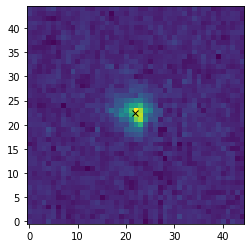

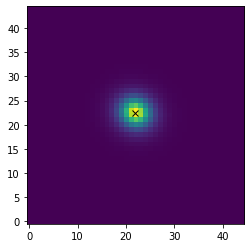

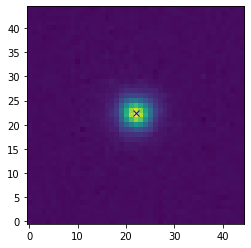

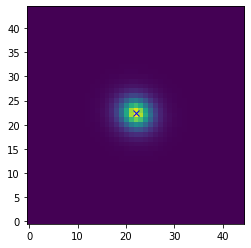

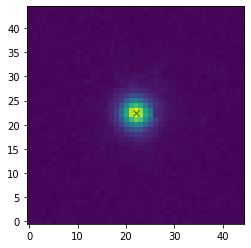

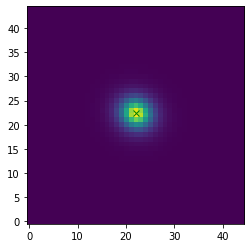

In [10]:
z = {"HE0021-1810":0.05352}

objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])